### Import Libraries

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import random
from PIL import Image
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D, AveragePooling2D
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import load_img, img_to_array

### Checking for GPU

In [2]:
if not tf.test.gpu_device_name():
    print('No GPU found. Please ensure you have installed TensorFlow correctly')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

Default GPU Device: /device:GPU:0


### Showing some of the images

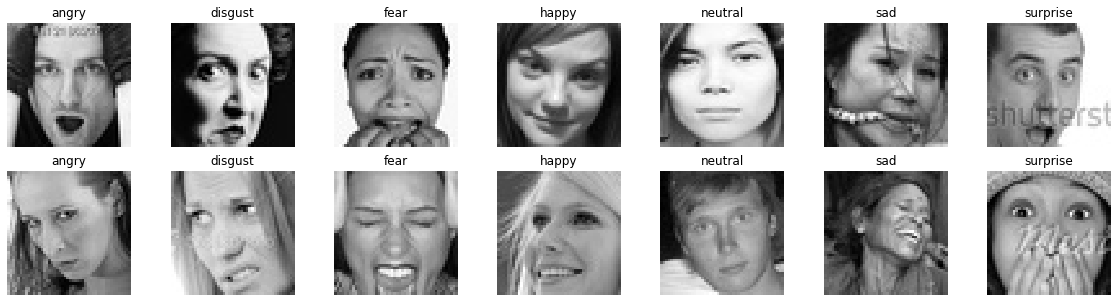

In [3]:
classes = os.listdir('train/')
samples = []
num_samples_class = 2   # number of photos per expression
exps = []
for sam in range(num_samples_class):
    for exp in os.listdir('train/'):
        img_name = f'train/{exp}/{random.choice(os.listdir(f"train/{exp}/"))}'
        samples.append(img_name)
        exps.append(exp)
plt.figure(figsize=(20, 5))
for n in range(len(samples)):
    plt.subplot(num_samples_class, 7, n+1)
    plt.imshow(Image.open(samples[n]), cmap='gray')
    plt.title(exps[n])
    plt.axis('off')

### Training dataset

In [4]:
print('Train Images:')
train_size = 0
for c in classes:
    train_size += len(os.listdir(f"train/{c}"))
    print(f'{len(os.listdir(f"train/{c}"))} {c} images')
print(f'Total: {train_size} images')

Train Images:
3995 angry images
436 disgust images
4097 fear images
7215 happy images
4965 neutral images
4830 sad images
3171 surprise images
Total: 28709 images


### Validation dataset

In [5]:
print('Test Images:')
test_size = 0
for c in classes:
    test_size += len(os.listdir(f"test/{c}"))
    print(f'{len(os.listdir(f"test/{c}"))} {c} images')
print(f'Total: {test_size} images')    

Test Images:
958 angry images
111 disgust images
1024 fear images
1774 happy images
1233 neutral images
1247 sad images
831 surprise images
Total: 7178 images


### Model architecture

In [6]:
model = Sequential()
input_shape = (48,48,1)
model.add(Conv2D(64, (5, 5), input_shape=input_shape,activation='relu', padding='same'))
model.add(Conv2D(64, (5, 5), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (5, 5),activation='relu',padding='same'))
model.add(Conv2D(128, (5, 5),activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3),activation='relu',padding='same'))
model.add(Conv2D(256, (3, 3),activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(6))
model.add(Activation('softmax'))

### Reading and prepearing the data for training
I didn't include the disgust expression data in the training for its small size to avoid imbalanced dataset. 

In [7]:
batch_size = 64
train_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()
train_gen = train_datagen.flow_from_directory('train/', batch_size=batch_size, class_mode='categorical', target_size=(48, 48),
                                             color_mode='grayscale', shuffle=True,
                                              classes=['angry', 'fear', 'happy', 'neutral', 'sad', 'surprise'])
test_gen = test_datagen.flow_from_directory('test/', batch_size=batch_size, class_mode='categorical', target_size=(48, 48),
                                           color_mode='grayscale',
                                           classes=['angry', 'fear', 'happy', 'neutral', 'sad', 'surprise'])

Found 28273 images belonging to 6 classes.
Found 7067 images belonging to 6 classes.


### Compiling the model and saving model's weights

In [8]:
optim = Adam(lr=0.0005)
model.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['accuracy'])

### Training the model

In [9]:
checkpoint = ModelCheckpoint('model_weights_3.h5', save_weights_only=True, monitor='val_accuracy', mode='max')
epochs = 20
history = model.fit_generator(train_gen, validation_data=test_gen, epochs=epochs, callbacks=[checkpoint])

Epoch 1/20
442/442 [==============================] - 52s 118ms/step - loss: 1.5663 - accuracy: 0.3851 - val_loss: 1.8010 - val_accuracy: 0.2482
Epoch 2/20
442/442 [==============================] - 50s 113ms/step - loss: 1.2050 - accuracy: 0.5317 - val_loss: 1.2111 - val_accuracy: 0.5264
Epoch 3/20
442/442 [==============================] - 50s 113ms/step - loss: 1.0445 - accuracy: 0.6021 - val_loss: 1.1085 - val_accuracy: 0.5756
Epoch 4/20
442/442 [==============================] - 50s 114ms/step - loss: 0.9367 - accuracy: 0.6456 - val_loss: 1.0714 - val_accuracy: 0.5928
Epoch 5/20
442/442 [==============================] - 50s 114ms/step - loss: 0.8195 - accuracy: 0.6954 - val_loss: 1.1326 - val_accuracy: 0.5905
Epoch 6/20
442/442 [==============================] - 51s 116ms/step - loss: 0.6846 - accuracy: 0.7509 - val_loss: 1.1045 - val_accuracy: 0.6041
Epoch 7/20
442/442 [==============================] - 51s 115ms/step - loss: 0.5315 - accuracy: 0.8080 - val_loss: 1.1937 - val_ac

### Training progress

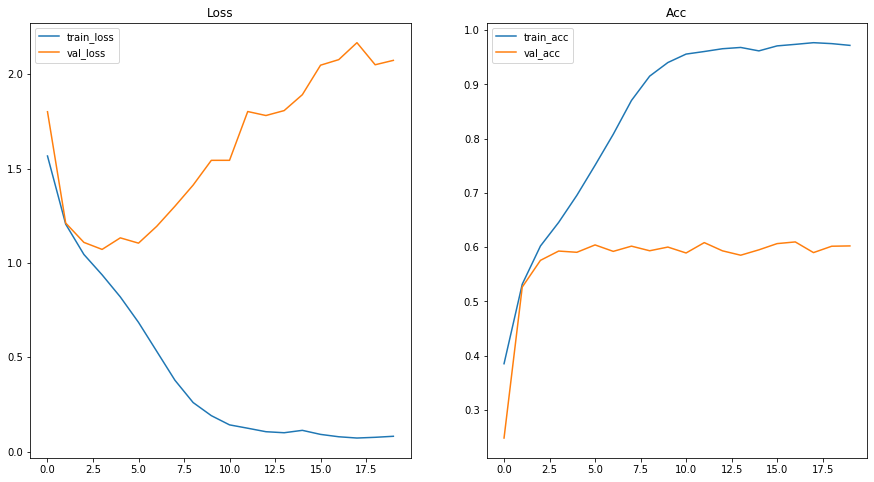

In [10]:
train_loss = history.history['loss']
train_acc = history.history['accuracy']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']
epoch_range = range(epochs)
plt.figure(figsize=(15,8))
plt.subplot(1, 2, 1)
plt.plot(epoch_range, train_loss, label='train_loss')
plt.plot(epoch_range, val_loss, label='val_loss')
plt.legend()
plt.title('Loss')
plt.subplot(1, 2, 2)
plt.plot(epoch_range, train_acc, label='train_acc')
plt.plot(epoch_range, val_acc, label='val_acc')
plt.legend()
plt.title('Acc')
plt.show();

### Loading the trained weights

In [11]:
model.load_weights('model_weights_3.h5')

### Predicting expressions

In [12]:
import cv2
from urllib import request

def predict_img(img_url, classes):
    req = request.urlopen(img_url)
    arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
    img = cv2.imdecode(arr, -1) # 'Load it as it is'
    img_show = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # plt.imshow(img_show)
    # plt.axis('off')

    font = cv2.FONT_HERSHEY_SIMPLEX
    face = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
    img_detect = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face.detectMultiScale(img_detect, 1.3, 5)

    for (x, y, w, h) in faces:
        fc = img_detect[y:y+h, x:x+w]
        roi = cv2.resize(fc, (48, 48))
        roi = np.float32(roi)
        img = roi[np.newaxis, :, :, np.newaxis]
        predict = model.predict(img)
        pred = classes[np.argmax(predict)]
        cv2.putText(img_show, pred, (x, y), font, 1, (255, 255, 0), 3)
        cv2.rectangle(img_show,(x,y),(x+w,y+h),(255,0,0),2)
        m = 20
        img_show = img_show[y-m:y+h+m, x-m:x+w+m]
        
#     plt.figure()
#     plt.imshow(img_show)
#     plt.axis('off');
        return img_show

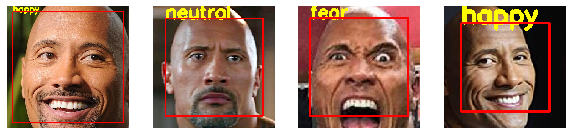

In [13]:
img_urls = ["https://i.insider.com/5b462c57f4af9c1a008b45eb?width=1073&format=jpeg",
            "https://d2j1wkp1bavyfs.cloudfront.net/wp-content/uploads/2018/07/the-fate-of-the-furious.png",
            "https://i.pinimg.com/originals/12/8b/8d/128b8debb2751f7e53d38ab2365991ea.jpg",
           "https://m.media-amazon.com/images/M/MV5BMTkyNDQ3NzAxM15BMl5BanBnXkFtZTgwODIwMTQ0NTE@._V1_UX214_CR0,0,214,317_AL_.jpg"]
classes = ['angry', 'fear', 'happy', 'neutral', 'sad', 'surprise']

imgs = [predict_img(url, classes) for url in img_urls]; 
plt.figure(figsize=(10, 5))
for n in range(len(imgs)):
    plt.subplot(1, len(imgs), n+1)
    plt.imshow(imgs[n])
    plt.axis('off')

### Saving the model to a json format

In [14]:
model_json = model.to_json()
with open("model.json", 'w') as json_file:
    json_file.write(model_json)